# Boulder Residential Property Valuation Appraiser


> Objectives
>
> - Implement a new version of the House Appraiser model with support for multiple features using XGBoost.
> - Use SciKit-Learn's Pipeline functionality for data preprocessing and model evaluation.
> - Perform Cross-Validation, a technique for gauging model generalizability and comparing model.
> - Use Hyperparameter Tuning to optimize training


## Runtime Environment Set Up


In [1]:
import sys, os
sys.path.insert(0, os.path.join('..', 'includes'))

import setup
setup.initialize_environment()
if setup.environment == 'VIRTUAL':
    %pip install -q python-dotenv==1.0.0 pandas==2.2.1 matplotlib==3.8.3 scikit-learn==1.4.1.post1 openpyxl seaborn geopy

🎉 Running in a Virtual environment

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


---


# Context

Given the methods described by [Boulder County Tax Assessor > Real Property Assessment & Valuation](https://bouldercounty.gov/property-and-land/assessor/assessment/), the Boulder County Assessor uses 24 months of sales data and up to 5 years prior if [not enough data](https://bouldercounty.gov/property-and-land/assessor/assessment/valuation/#:~:text=An%2018%2Dmonth%20base%20period%20is%20used%20for%20property%20assessment%20by%20statute.%20To%20take%20into%20account%20any%20seasonality%20of%20sales%2C%20the%20Boulder%20County%20Assessor%20uses%2024%20months%20of%20sales%20data.%20If%20there%20are%20not%20enough%20sales%20during%20that%20time%2C%20up%20to%20five%20years%20of%20data%20can%20be%20used%20for%20comparison%20purposes.) is available.

## Time Trend Analysis

The assessor's site refers to the concept of a [Time Trend Adjustment](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/time-trend/) that is used in the following fashion to generate an appraised valuation for a particular property.

![Time Trend Adjustment factoring](./assets/sales_price_estimator.png)


The county maintains a publicly accessible list of [Time Trend Factors](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/factors/) for which the time trend factors for 2023 are included in this study along with the corresponding sales data:
- [2023 Boulder Residential Time Trends](./assets/ar-trend-2023-residential-boulder-sheet.xlsx) published April 26, 2023
- [Market Area 101 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-101-sheet.xlsx)
- [Market Area 102 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-102-sheet.xlsx)
- [Market Area 103 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-103-sheet.xlsx)
- [Market Area 104 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-104-sheet.xlsx)
- [Market Area 105 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-105-sheet.xlsx)
- [Market Area 106 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-106-sheet.xlsx)
- [Market Area 107 Comparable Sales XLSX](./assets/boulder_sales_2024/ar-comp-2024-residential-107-sheet.xlsx)

## Exercise Goals:


- In this exercise we will be using Decision Tree Regression model to predict a house's price, given other features about the house.
  - This model will be able to perform multiple regression — using multiple features to perform prediction — like you did with SciKit-Learn in previous exercises.


## Imports


In [2]:
import pandas as pd  # interface for data loading
import matplotlib.pyplot as plt  # visualization
from sklearn.model_selection import train_test_split  # splitting data
from sklearn.metrics import mean_absolute_error  # evaluation metric
from sklearn.compose import ColumnTransformer  # processing columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # processing string data
from sklearn.impute import SimpleImputer  # processing missing data
from sklearn.pipeline import Pipeline  # pipeline constructor
from sklearn.model_selection import cross_val_score  # cross-validation
from sklearn.model_selection import GridSearchCV  # hyperparameter tuning
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, LabelBinarizer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import seaborn as sns
import time

## Data Utilities

Helpful loading and normalizing functions

In [3]:
import pandas as pd
import os
import numpy as np

def merge_excel_sheets(folder_path: str):
    """
    Merges multiple Excel sheets within a folder into a single pandas DataFrame.

    Args:
    folder_path: Path to the folder containing the Excel files.

    Returns:
    A pandas DataFrame containing the merged data.
    """

    # Get a list of all Excel files in the folder
    excel_files = [f for f in os.listdir(folder_path) if f.endswith('.xlsx')]

    # Create an empty list to store DataFrames
    dataframes = []

    # Load each Excel file into a DataFrame and append to the list
    for file in excel_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_excel(file_path, dtype=str)
        dataframes.append(df)

    # Merge all DataFrames into a single DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)

    return merged_df


def clean_numerical_features(df, price_features=[], surface_area_features=[]):
    """
    Cleans numerical and date columns in a DataFrame by standardizing formats and converting types.

    Args:
    df: A pandas DataFrame.
    price_features: List of pricing columns (with $ and commas).
    surface_area_features: List of square footage properties.

    Returns:
    A pandas DataFrame with cleaned column data.
    """

    # ✅ Ensure Currency Columns Are Float
    df[price_features] = df[price_features].applymap(lambda x: str(x).replace("$", "").replace(",", ""))
    df[price_features] = df[price_features].astype(float)

    # ✅ Ensure Numerical Columns Are Float
    df[surface_area_features] = df[surface_area_features].replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')

    return df


def save_to_csv(df, file_path: str):
    """
    Saves a DataFrame to a CSV file.

    Args:
    df: A pandas DataFrame.
    file_path: Path to save the CSV file.
    """

    df.to_csv(file_path, index=False)


---

# Data Source - Boulder County Time Trends

In accordance with Colorado law, we are restricting use of property sales data to that which is allowed and published [here](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/factors/) for 2023 Boulder Residential Time Trends.

Leveraging the [comparable property sales data](https://bouldercounty.gov/property-and-land/assessor/sales/comps-2023/residential/#Market-Area-101) as published on the public site for reference in performing the market approach of valuation analysis.

## Location matters (~40min)

Geoencode subject property addresses for capturing proximity space dependencies more precisely than Market Area bounding box alone.

![Market Area map](./assets/ar-trend-2023-map-overview.png)

Given the similarity in geological, school zoning, population density, and area sizing features, we've restricted our data set to the 100 Market Area series. Consequently, this could be considered an "residential urban property value predictive model".

The following are the corresponding Time Trend Factors for 2023 for the 100 Market Area series:

<table style="width: 100%;">
  <tr>
    <td style="width: 50%; text-align: center;">
      <img src="./assets/ar-trend-2023-residential-boulder-list-1.png" alt="Time Trend Factors 1/2" style="max-width: 100%; height: auto;">
    </td>
    <td style="width: 50%; text-align: center;">
      <img src="./assets/ar-trend-2023-residential-boulder-list-2.png" alt="Time Trend Factors 2/2" style="max-width: 100%; height: auto;">
    </td>
  </tr>
</table>


In [6]:
from geopy.geocoders import Nominatim, GoogleV3
from geopy.exc import GeocoderTimedOut
from sklearn.base import BaseEstimator, TransformerMixin
from setup import load_environment_variable
# from caffeinate_manager import start_caffeinate, stop_caffeinate


class GeocodeTransformer(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer for geocoding addresses into latitude/longitude.

    Nominatim usage policy: https://operations.osmfoundation.org/policies/nominatim/

    © OpenStreetMap https://www.openstreetmap.org/copyright contributors

    Parameters:
    - street_number: Column name for the street number
    - street_dir: Column name for the street direction (E, N, W, S)
    - street_name: Column name for the street name
    - street_suffix: Column name for the street suffix (Ave, St, Rd)
    - location: Column name for the city/location
    - unincorporated: Name of the unincorporated area (default: "Boulder")
    - batch_size: Number of rows to process per batch (default: 50)
    - batch_delay: Number of seconds to wait between batches (default: 1)
    - user_agent: Unique user agent for geopy (default: "property_geocoder")
    """

    def __init__(self, street_number, street_dir, street_name, street_suffix, location, unincorporated, batch_size=50, batch_delay=1, user_agent="property_geocoder"):
        self.street_number = street_number
        self.street_dir = street_dir
        self.street_name = street_name
        self.street_suffix = street_suffix
        self.location = location
        self.unincorporated = unincorporated
        self.batch_size = batch_size
        self.batch_delay = batch_delay
        self.user_agent = user_agent
        self.geolocator = Nominatim(user_agent=self.user_agent, timeout=10)
        self.geolocator_backup = GoogleV3(api_key=load_environment_variable("GOOGLE_API_KEY"), user_agent=self.user_agent, timeout=10)

    def _get_lat_lon(self, address):
        """Fetches lat/lon with retries."""
        if pd.isna(address) or address.strip() == "":
            return pd.Series([None, None])  # Handle empty addresses

        attempt = 0
        while attempt < 3:  # Retry up to 3 times if a timeout occurs
            try:
                address = address.replace("UNINCORPORATED", self.unincorporated)
                location = self.geolocator.geocode(address)
                if location:
                    print(f"Geocoded (primary locator): {address} -> {location.latitude}, {location.longitude}")
                    return pd.Series([location.latitude, location.longitude])
                else:
                    location = self.geolocator_backup.geocode(address)
                    if location:
                        print(f"Geocoded (backup locator): {address} -> {location.latitude}, {location.longitude}")
                        return pd.Series([location.latitude, location.longitude])
                    print(f"No result found for: {address}")
                    return pd.Series([None, None])  # No result found
            except GeocoderTimedOut:
                attempt += 1
                time.sleep(2)  # Wait before retrying

        return pd.Series([None, None])  # Return None if all attempts fail

    def _use_lat_lon(self, row, address_column, overwrite=False):
        """Returns the latitude/longitude if available, else fetches it."""
        if not overwrite and pd.notna(row['lat']) and pd.notna(row['lon']):
            return pd.Series([row['lat'], row['lon']])
        else:
            return self._get_lat_lon(row[address_column])

    def _set_coordinate_cols(self, df):
        # Ensure 'lat' and 'lon' exist and set to None if missing
        for col in ["lat", "lon"]:
            if col not in df.columns:
                df[col] = None  # Create column with None if missing
            else:
                df.loc[df[col].isna() | (df[col] == ""), col] = None  # Replace NaN/empty with None
        return df

    def _batch_geocode(self, df, address_column, overwrite=False):
        """Processes geocoding in batches to avoid rate limiting."""
        df = self._set_coordinate_cols(df)

        for i in range(0, len(df), self.batch_size):
            batch = df.iloc[i:i + self.batch_size].copy()

            print(f'Geocoding batch {i + 1}-{i + len(batch)} ... {"(overwriting)" if overwrite else "(retain existing)"}')
            batch[['lat', 'lon']] = batch.apply(lambda row: self._use_lat_lon(row, address_column, overwrite), axis=1)

            df.iloc[i:i + self.batch_size, df.columns.get_loc('lat')] = batch['lat']
            df.iloc[i:i + self.batch_size, df.columns.get_loc('lon')] = batch['lon']

            time.sleep(self.batch_delay)  # Pause to avoid rate limiting

        return df

    def fit(self, X, y=None):
        """No fitting required, returns self."""
        return self

    def transform(self, X, overwrite=False):
        """Adds latitude/longitude columns to the DataFrame."""
        X = X.copy()  # Avoid modifying original dataset

        # Construct full address column
        X['full_address'] = (
            X[self.street_number].astype(str) + " " +
            X[self.street_dir].fillna('') + " " +
            X[self.street_name] + " " +
            X[self.street_suffix].fillna('') + ", " +
            X[self.location] + ", CO"
        ).str.replace(' +', ' ', regex=True).str.strip()

        # Perform batch geocoding
        X = self._batch_geocode(X, address_column='full_address', overwrite=overwrite)

        X.drop(columns=['full_address'], inplace=True)  # Remove temporary column
        return X # Return full enriched DataFrame

# ---------- UNCOMMENT BELOW TO RUN LONG RUNNING CODE TO GEOCODE ADDRESSES -------------------

# 1. Original data source
# folder_path = './assets/boulder_sales_2024'
# boulder_sales_2024_df = merge_excel_sheets(folder_path)
# print("Boulder raw sales 2024 data shape:", boulder_sales_2024_df.shape)
# print(boulder_sales_2024_df.info())
# print(boulder_sales_2024_df.columns.to_list())
# print(boulder_sales_2024_df.head())

# 2. Existing data source
boulder_sales_2024_df = pd.read_csv('./assets/boulder_sales_2024__geocoded.csv')

geo_transformer = GeocodeTransformer(
    street_number="Property Address Street Number",
    street_dir="Property Address Street Dir",
    street_name="Property Address Street Name",
    street_suffix="Property Address Street Suffix",
    location="Location",
    unincorporated="Boulder",
    batch_size=50,
    batch_delay=1,
    user_agent="boulder_property_locator"
)

# start_caffeinate()  # Prevent system sleep during geocoding
# Enrich the columns of the DataFrame with lat/lon
boulder_sales_2024_df = geo_transformer.transform(boulder_sales_2024_df)
# stop_caffeinate()  # Allow system sleep after geocoding

# Save the geo enriched  data to a CSV file
save_to_csv(boulder_sales_2024_df, 'assets/boulder_sales_2024__geocoded.csv')


Geocoding batch 1-50 ... (retain existing)
Geocoding batch 51-100 ... (retain existing)
Geocoding batch 101-150 ... (retain existing)
Geocoding batch 151-200 ... (retain existing)
Geocoding batch 201-250 ... (retain existing)
Geocoding batch 251-300 ... (retain existing)
Geocoding batch 301-350 ... (retain existing)
Geocoding batch 351-400 ... (retain existing)
Geocoding batch 401-450 ... (retain existing)
Geocoding batch 451-500 ... (retain existing)
Geocoding batch 501-550 ... (retain existing)
Geocoding batch 551-600 ... (retain existing)
Geocoding batch 601-650 ... (retain existing)
Geocoding batch 651-700 ... (retain existing)
Geocoding batch 701-750 ... (retain existing)
Geocoding batch 751-800 ... (retain existing)
Geocoding batch 801-850 ... (retain existing)
Geocoding batch 851-900 ... (retain existing)
Geocoding batch 901-950 ... (retain existing)
Geocoding batch 951-1000 ... (retain existing)
Geocoding batch 1001-1050 ... (retain existing)
Geocoding batch 1051-1100 ... (reta

## Feature engineering

Enriching the source data with location attributes allows for more precise and accurate property valuation given regional variance.

Let's begin by loading the data

- [x] Explore the data in `boulder_sales_2024__geocoded.csv` and note the available features.
- [x] Pre-process the columns to be properly vectorized for exploration and distribution characterization
- [x] Split the dataset into subsets using SciKit-Learn's `train_test_split`


In [15]:
# Plan of action (from team feedback)

# PART I - PROTEST
# 1. Talk with ML expert contracted by the county - "what are the assumptions?"
# 2. Protest "if you can provide analysis that shows the model is wrong"
# 2b. break windows
# 2c. show leaky roofs
# 2d. can you show characteristics that would sell for the blue number? split-screen "my house" vs "Tony Starks house"

# PART II - ETHICAL ML MODEL
# Define fairness?? What does that mean? I'm a homeowner, i will make all the coefficients negative
# - metrics of success (other counties not doing so hot! prove we can have negative coefficients and the generalizability of the model)

# ML Trend Forecast Expert Questions:
# - resolution of predictions?
# - periodic retraining?
# - hyperparameters?
# - what is the model? (should be open sourced for transparency to tax payers, not require reverse engineering)
# - dataset size too limited? small, sparse, not enough data, why not stick to heuristics or historically accurate CMA?
# - what is the model's confidence interval?
# - what is the model's accuracy?
# - what is the model's precision?
# - what is the model's recall?
# - what is the model's F1 score?
# - what is the model's ROC-AUC?
# - what is the model's PR-AUC?
# - what is the model's calibration curve?
# - what is the model's confusion matrix?
# - what is the model's feature importance?


# Define transforms
# "Time Trends" magic numbers

# 1. Load and enrich the dataset
boulder_sales_2024_df = pd.read_csv("assets/boulder_sales_2024__geocoded.csv")
print("Boulder sales 2024 data shape:", boulder_sales_2024_df.shape)
print(boulder_sales_2024_df.head())

Boulder sales 2024 data shape: (2492, 26)
  Accout Number Property Type  Property Address Street Number  \
0      R0002164           Res                             308   
1      R0003172           Res                             204   
2      R0007146           Res                             215   
3      R0007147           Res                             235   
4      R0005514           Res                             265   

  Property Address Street Dir Property Address Street Name  \
0                         NaN                         27TH   
1                         NaN                         28TH   
2                         NaN                         28TH   
3                         NaN                         28TH   
4                         NaN                         28TH   

  Property Address Street Suffix Property Address Unit Number Location Design  \
0                             ST                          NaN  BOULDER  Ranch   
1                             ST

### Feature pruning

In [17]:
# determine any empty rows missing lat/lon
missing_geocode = boulder_sales_2024_df[boulder_sales_2024_df['lat'].isnull() | boulder_sales_2024_df['lon'].isnull()]

# remove the rows with missing lat/lon
boulder_sales_2024_df = boulder_sales_2024_df.dropna(subset=['lat', 'lon'])

remove_columns = [
    "Accout Number",
    "Reception No",
    "Property Address Street Suffix",
    "Property Address Unit Number",
    "Property Address Street Name",
    "Property Address Street Number",
    "Location",
]
print(f'Removing columns: {remove_columns}')
boulder_sales_2024_df = boulder_sales_2024_df.drop(columns=remove_columns, errors="ignore")

surface_area_features = [
    "Garage SF",
    "Above Grd SF",
    "Basemt Tot SF",
    "Basemt Fin SF",
    "Basemt Unf SF",
    "Est Land SF",
]
price_features = ["Sale Price", "Time Adjust Sales Price"]
boulder_sales_2024_df = clean_numerical_features(
    boulder_sales_2024_df,
    price_features=price_features,
    surface_area_features=surface_area_features
)

# Display the unique values in each column (except for the price columns)
for column_name in boulder_sales_2024_df.columns:
    if column_name not in price_features:
        print(boulder_sales_2024_df[column_name].value_counts().sort_index())

for price_column in price_features:
    # print min, max, mean, median, std, 25%, 50%, 75%
    print(f"Price column: {price_column}")
    print(boulder_sales_2024_df[price_column].describe())

Removing columns: ['Accout Number', 'Reception No', 'Property Address Street Suffix', 'Property Address Unit Number', 'Property Address Street Name', 'Property Address Street Number', 'Location']
Property Type
Dup/Tri      82
Res        2409
Name: count, dtype: int64
Property Address Street Dir
E    21
N     6
S    96
W     6
Name: count, dtype: int64
Design
2-3 Story      1209
Bi-Level        115
Ranch           903
Split-Level     264
Name: count, dtype: int64
Quality
Average      1200
Excellent      79
Fair            1
Good          851
Very Good     360
Name: count, dtype: int64
Eff Yr Built
1905     1
1920     1
1930     1
1940     1
1947     1
        ..
2018    20
2019    12
2020     5
2021     3
2022     1
Name: count, Length: 77, dtype: int64
Above Grd SF
430     1
440     1
480     1
486     1
510     1
       ..
6244    1
6268    1
6328    1
6556    1
7659    1
Name: count, Length: 1400, dtype: int64
Basemt Tot SF
0       874
18        1
26        1
55        1
57        1


/var/folders/zx/qs5pg9y93w36q1r9vt3dwv6h0000gn/T/ipykernel_68663/2402629055.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[price_features] = df[price_features].applymap(lambda x: str(x).replace("$", "").replace(",", ""))


### Plot of raw dataset

/var/folders/zx/qs5pg9y93w36q1r9vt3dwv6h0000gn/T/ipykernel_68663/2656119289.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  market_area_df = market_area_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["assumed_appreciation"])  # Remove unrealistic appreciation values
/var/folders/zx/qs5pg9y93w36q1r9vt3dwv6h0000gn/T/ipykernel_68663/2656119289.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  market_area_df = market_area_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["assumed_appreciation"])  # Remove unrealistic 

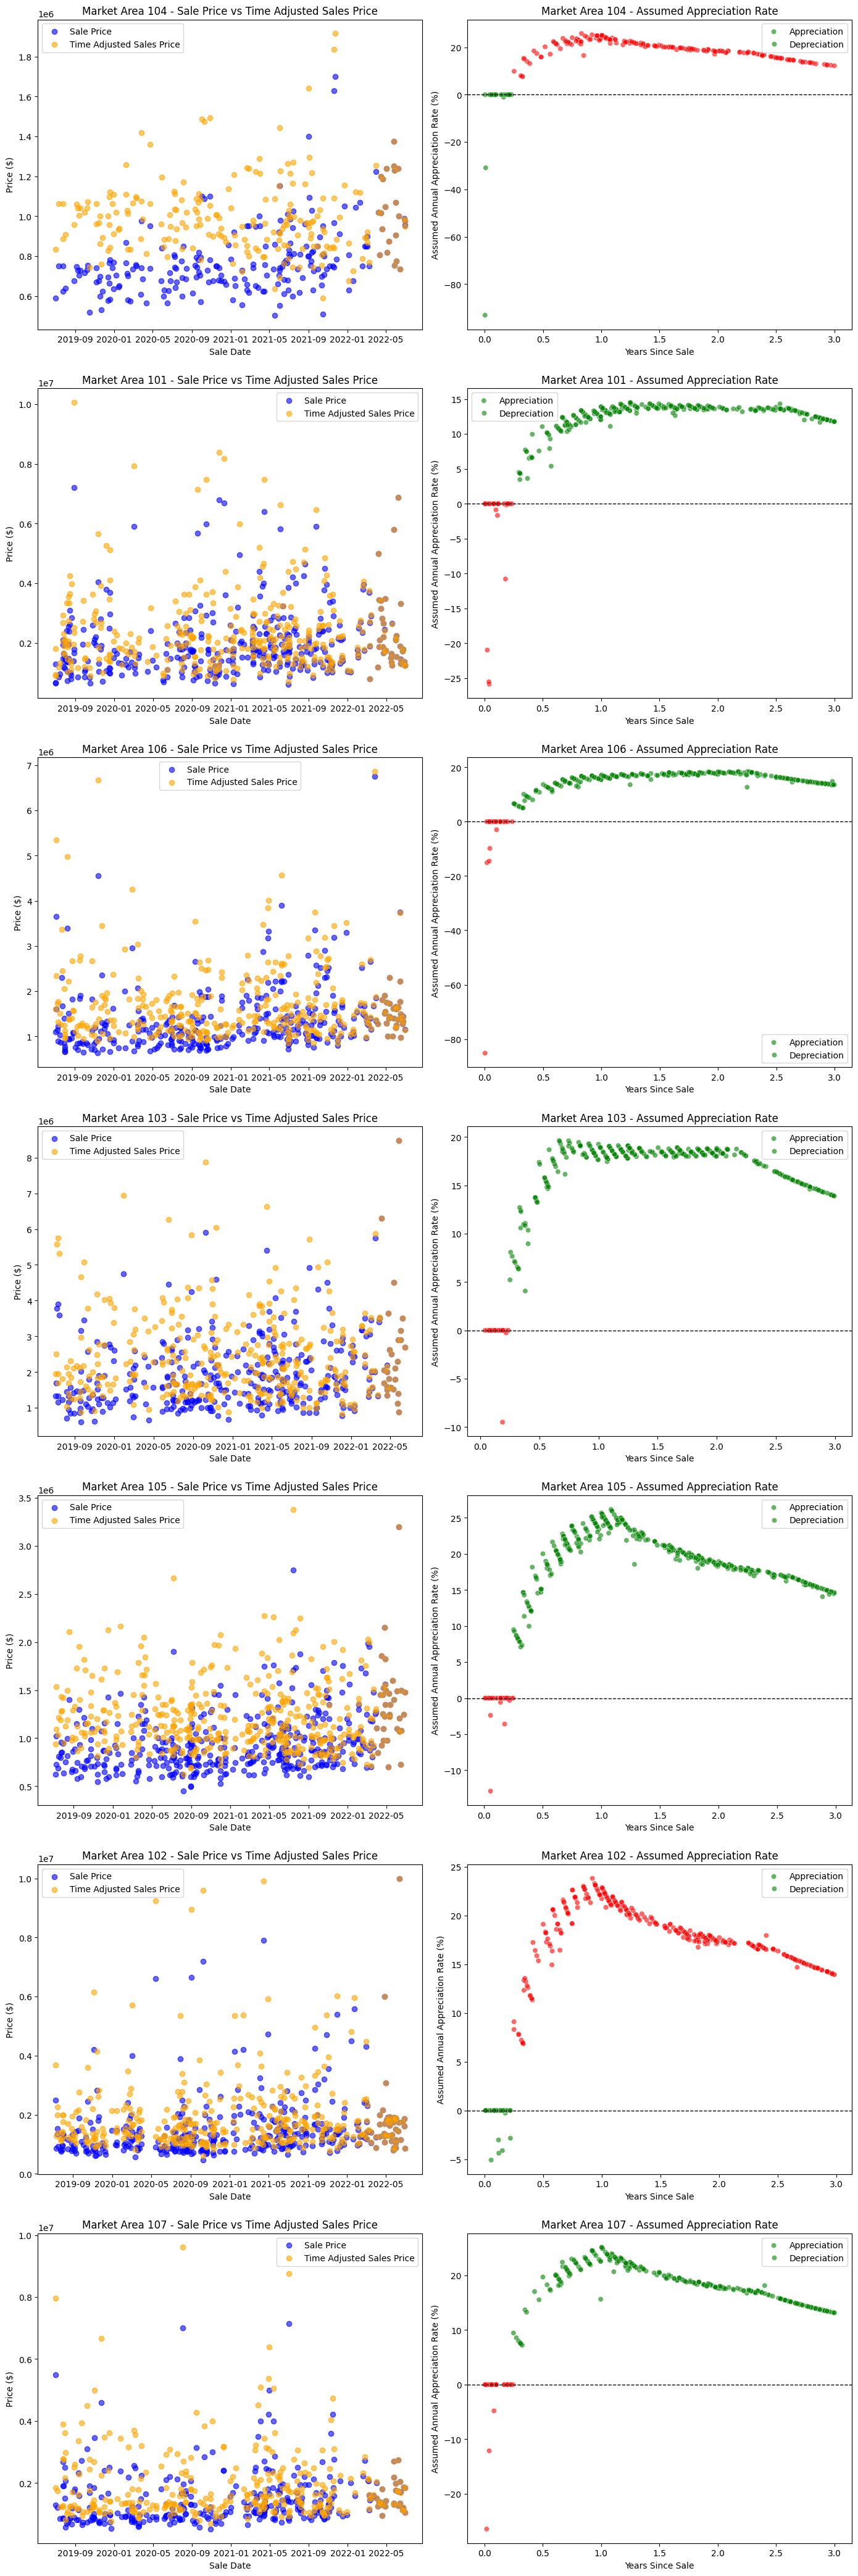

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

boulder_official_appraisal_date = pd.Timestamp("2022-06-30")

# Ensure sale dates are in datetime format
boulder_sales_2024_df["Sale Date"] = pd.to_datetime(boulder_sales_2024_df["Sale Date (Mon-Yr)"])

# Get unique market areas
market_areas = boulder_sales_2024_df["Market Area"].unique()

# Create a figure with subplots (adjust size based on number of market areas)
fig, axes = plt.subplots(len(market_areas), 2, figsize=(14, len(market_areas) * 6))

# Ensure axes is always a 2D array, even if only one market area exists
if len(market_areas) == 1:
    axes = np.array([axes])  # Convert 1D array to 2D for uniform indexing

# Loop over each market area to create subplots
for i, market_area in enumerate(market_areas):
    # Filter the data for the current market area
    market_area_df = boulder_sales_2024_df[boulder_sales_2024_df["Market Area"] == market_area].copy()

    # Skip if there's not enough data
    if market_area_df.empty:
        continue

    # Calculate the price difference (TASP - Sale Price)
    market_area_df["price_diff"] = market_area_df["Time Adjust Sales Price"] - market_area_df["Sale Price"]

    # Calculate the assumed appreciation rate per year
    # Assuming that TASP is the estimated current value based on historical sales
    market_area_df["years_since_sale"] = (boulder_official_appraisal_date - market_area_df["Sale Date"]).dt.days / 365.0
    # Ensure no division by zero for recent sales
    market_area_df = market_area_df[market_area_df["years_since_sale"] > 0]
    # Compound annual growth rate (CAGR) formula to estimate the annual appreciation rate:
    market_area_df["assumed_appreciation"] = (((market_area_df["Time Adjust Sales Price"] / market_area_df["Sale Price"]) ** (1 / market_area_df["years_since_sale"])) - 1) * 100
    market_area_df = market_area_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["assumed_appreciation"])  # Remove unrealistic appreciation values

    # Define colors: Red if TASP > Sale Price, Green if TASP < Sale Price
    colors = np.where(market_area_df["price_diff"] > 0, "red", "green")

    # ---- Subplot 1: Sale Price vs. TASP Over Time ----
    axes[i, 0].scatter(
        market_area_df["Sale Date"],
        market_area_df["Sale Price"],
        label="Sale Price",
        color="blue",
        alpha=0.6
    )
    axes[i, 0].scatter(
        market_area_df["Sale Date"],
        market_area_df["Time Adjust Sales Price"],
        label="Time Adjusted Sales Price",
        color="orange",
        alpha=0.6
    )

    # Labels and title
    axes[i, 0].set_xlabel("Sale Date")
    axes[i, 0].set_ylabel("Price ($)")
    axes[i, 0].set_title(f"Market Area {market_area} - Sale Price vs Time Adjusted Sales Price")
    axes[i, 0].legend()

    # ---- Subplot 2: Assumed Appreciation Rate ----
    sns.scatterplot(
        x=market_area_df["years_since_sale"],
        y=market_area_df["assumed_appreciation"],
        hue=colors,
        palette=["green", "red"],
        alpha=0.6,
        ax=axes[i, 1]
    )

    # Labels and title
    axes[i, 1].axhline(0, color="black", linestyle="--", linewidth=1)  # Baseline at zero appreciation
    axes[i, 1].set_xlabel("Years Since Sale")
    axes[i, 1].set_ylabel("Assumed Annual Appreciation Rate (%)")
    axes[i, 1].set_title(f"Market Area {market_area} - Assumed Appreciation Rate")
    axes[i, 1].legend(["Appreciation", "Depreciation"])

# Adjust layout
plt.tight_layout()
plt.show()

### Price & layout features

Given the wide ranges in square footage and pricing, normalize the variance to faciliate model training.

In [19]:
# Function to apply log transformation for skewed values
numerical_log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

### Time features

Empirically in Comparative Market Analysis (CMA), residential sales trends exhibit seasonality.

In [20]:
# Function to extract all date-based features
time_features = ["Sale Date (Mon-Yr)"]
def extract_time_features(X):
    X = pd.to_datetime(X.iloc[:, 0])  # Ensure it's a datetime column
    return pd.DataFrame({
        "sale_year": X.dt.year,
        "sale_month": X.dt.month,
        "sale_day": X.dt.day,
        "sale_weekday": X.dt.weekday,  # 0 = Monday, 6 = Sunday
        "sale_quarter": X.dt.quarter,
        "sale_days_since_epoch": (X - pd.Timestamp("1970-01-01")) // pd.Timedelta(days=1),
        "sale_month_sin": np.sin(2 * np.pi * X.dt.month / 12),
        "sale_month_cos": np.cos(2 * np.pi * X.dt.month / 12),
        "sale_weekday_sin": np.sin(2 * np.pi * X.dt.weekday / 7),
        "sale_weekday_cos": np.cos(2 * np.pi * X.dt.weekday / 7)
    })

# Expand time-based feature set in order to capture any cyclical patterns
time_transformer = FunctionTransformer(
    func=extract_time_features,
    feature_names_out=lambda _, input_features: [
        "sale_year", "sale_month", "sale_day", "sale_weekday", "sale_quarter",
        "sale_days_since_epoch", "sale_month_sin", "sale_month_cos",
        "sale_weekday_sin", "sale_weekday_cos"
    ])

# Min-Max scaling for year
year_features = ["Eff Yr Built"]
year_transformer = MinMaxScaler()

### Location features

Empirically in CMA it also holds that residential sales trends are strongly correlated to location and configuration ie "cul de sac", "busy street", "family neighborhood", "near good school", "natural park nearby"... for an initial set of location features we've additionally included latitude/longitude and cardinal (NWSE) orientation of the property.

In [21]:
# Standard scaling for latitude/longitude
geo_features = ["lat", "lon"]
geo_transformer = StandardScaler()

# Custom transformer for cardinal directions (Trigonometric Encoding)
direction_features = ["Property Address Street Dir"]
def direction_transform(X):
    direction_map = { "N": 0, "E": 90, "S": 180, "W": 270 }

    # Ensure X is a NumPy array of strings to avoid NoneType issues
    X = np.array(X, dtype=str)

    # Replace any "nan" strings or None with "N" (default direction)
    X = np.where((X == "nan") | (pd.isna(X)) | (X == None), "N", X)

    # Convert mapped values to angles
    X = np.vectorize(direction_map.get)(X)

    # Compute sin and cos transformations
    sin_X = np.sin(np.radians(X))
    cos_X = np.cos(np.radians(X))

    # Return transformed features
    return np.c_[sin_X, cos_X]

direction_transformer = FunctionTransformer(
    direction_transform,
    feature_names_out=lambda _, input_features: ["direction_sin", "direction_cos"]
)

### Condition (categorical) features

Convert quality, sale condition, design, and garage configuration as additional categorical encodings to factor into the model

In [13]:
binary_features = [
    "Distress Sale",
    "Property Type",
]
binary_transformer = OneHotEncoder(drop="if_binary", sparse_output=False)  # Handles two unique values as binary encoding

categorical_features = [
    "Design",
    "Garage Type",
]
# Define an imputer that fills empty values with "Attached"
categorical_imputer = SimpleImputer(strategy="constant", fill_value="Attached")
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_pipeline = Pipeline([
    ("imputer", categorical_imputer),
    ("encoder", categorical_transformer)
])

# Convert ordinal category with values
quality_features = ["Quality"]
quality_order = ['Excellent', 'Very Good', 'Good', 'Average', 'Fair']
quality_transformer = OrdinalEncoder(categories=[list(reversed(quality_order))])

### Preprocessing Pipeline

For Decision Trees sales price should not need to be normalized (vs regression and MLP).

In [154]:
preprocessor = ColumnTransformer(
    transformers = [
        ("numerical_log_transform", numerical_log_transformer, surface_area_features),
        ("std_scale", geo_transformer, geo_features),
        ("minmax_scale", year_transformer, year_features),
        ('time_encoder', time_transformer, time_features),
        ('categorical_encoder', categorical_pipeline, categorical_features),
        ('binarizer', binary_transformer, binary_features),
        ('direction_encoder', direction_transformer, direction_features),
        ('quality_encoder', quality_transformer, quality_features),
    ],
    remainder="drop"
)

# 🚀 **Step 1: Extract & Log-Transform Target (y) BEFORE Applying Preprocessing**
y_log = np.log1p(boulder_sales_2024_df["Sale Price"])  # Log-transform sale price
y_log_tasp = np.log1p(boulder_sales_2024_df["Time Adjust Sales Price"])  # Log-transform time-adjusted sale price

# 🚀 **Step 2: Drop Target Columns from Feature Data BEFORE Applying Preprocessing**
X_df = boulder_sales_2024_df.drop(columns=["Sale Price", "Time Adjust Sales Price"])  # Drop target before processing

# Apply the preprocessor to the dataset
X = preprocessor.fit_transform(X_df)

# Check for missing values after transformation
print("Missing values in X_train:")
X_train_df = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
print(X_train_df.isnull().sum().sort_values(ascending=False))

# If any column still has NaN values, print the offending rows
for col in X_train_df.columns:
    if X_train_df[col].isnull().sum() > 0:
        print(f"❌ Column '{col}' contains missing values: {X_train_df[col].unique()}")
        print(X_train_df[X_train_df[col].isnull()])
        print("\n")

print("Preprocessed data shape:", X.shape)
print("Preprocessed data columns:", preprocessor.get_feature_names_out())
print("Original Data Columns:", boulder_sales_2024_df.shape[1])
print("Transformed Data Columns:", len(preprocessor.get_feature_names_out()))

Missing values in X_train:
numerical_log_transform__Garage SF           0
categorical_encoder__Garage Type_Carport     0
categorical_encoder__Design_2-3 Story        0
categorical_encoder__Design_Bi-Level         0
categorical_encoder__Design_Ranch            0
categorical_encoder__Design_Split-Level      0
categorical_encoder__Garage Type_Attached    0
categorical_encoder__Garage Type_Basement    0
categorical_encoder__Garage Type_Detached    0
numerical_log_transform__Above Grd SF        0
categorical_encoder__Garage Type_Multiple    0
categorical_encoder__Garage Type_Workshop    0
binarizer__Distress Sale_Yes                 0
binarizer__Property Type_Res                 0
direction_encoder__direction_sin             0
direction_encoder__direction_cos             0
time_encoder__sale_weekday_cos               0
time_encoder__sale_weekday_sin               0
time_encoder__sale_month_cos                 0
time_encoder__sale_month_sin                 0
time_encoder__sale_days_since_epo

## Model training

The regression model of choice is a decision tree for its explainability and maintenance — a function that produces a probable output based on a particular feature.

### Data splitting

      numerical_log_transform__Garage SF  \
290                             6.493754   
599                             5.697093   
1264                            5.493061   
2029                            6.091310   
416                             6.311735   

      numerical_log_transform__Above Grd SF  \
290                                7.826044   
599                                6.960348   
1264                               7.156956   
2029                               7.888710   
416                                8.310169   

      numerical_log_transform__Basemt Tot SF  \
290                                 7.172425   
599                                 0.000000   
1264                                6.529419   
2029                                7.142827   
416                                 6.343880   

      numerical_log_transform__Basemt Fin SF  \
290                                 7.172425   
599                                 0.000000   
1264               

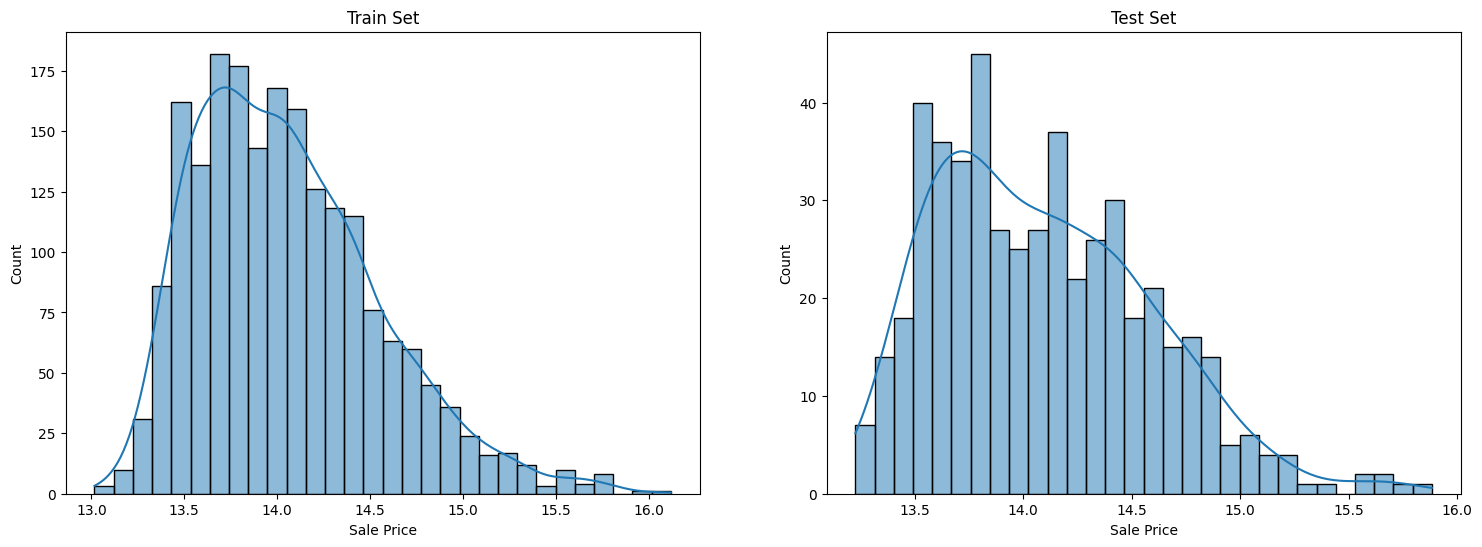


      Skew Assessment:
      Interpretation:
	•	|Skew| < 1.0 → Slight skew, usually fine
	•	|Skew| > 1.0 → Moderate skew, consider transforming
	•	|Skew| > 2.0 → Highly skewed, transformation recommended
      
Sales Price Skew:
 Train -> 0.7860671186463666 
Test -> 0.6605714840245026


In [187]:
# Validation & training sets handled internally by grid search
X_train, X_test, y_train, y_test = train_test_split(X_train_df, y_log, test_size=0.2, random_state=42)

print(X_train.head())

# plot samples of x train and x test to inspect the distribution of the features
# plot histograms of the target variable in the train, val, and test sets
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(y_train, bins=30, kde=True, ax=axes[0])
axes[0].set_title('Train Set')
sns.histplot(y_test, bins=30, kde=True, ax=axes[1])
axes[1].set_title('Test Set')
plt.show()

print("""
      Skew Assessment:
      Interpretation:
	•	|Skew| < 1.0 → Slight skew, usually fine
	•	|Skew| > 1.0 → Moderate skew, consider transforming
	•	|Skew| > 2.0 → Highly skewed, transformation recommended
      """)
print("Sales Price Skew:\n", "Train ->", y_train.skew(), "\nTest ->", y_test.skew())

### Model Selection

In [188]:
# You can tune hyperparameters like max_depth to improve the model's performance
from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize a decision tree regressor with default parameters
model = DecisionTreeRegressor(criterion="poisson", random_state=42)

print(X_train.head())
print(y_train.head())
print(X_test.head())

      numerical_log_transform__Garage SF  \
290                             6.493754   
599                             5.697093   
1264                            5.493061   
2029                            6.091310   
416                             6.311735   

      numerical_log_transform__Above Grd SF  \
290                                7.826044   
599                                6.960348   
1264                               7.156956   
2029                               7.888710   
416                                8.310169   

      numerical_log_transform__Basemt Tot SF  \
290                                 7.172425   
599                                 0.000000   
1264                                6.529419   
2029                                7.142827   
416                                 6.343880   

      numerical_log_transform__Basemt Fin SF  \
290                                 7.172425   
599                                 0.000000   
1264               

### Tune & Train

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Initialize Grid Search with 5-fold CV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error")

# Train with GridSearchCV (uses training & validation data internally)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Print best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Train the model on the training data
model = best_model.fit(X_train, y_train)

# Make predictions on test data
y_pred_test = model.predict(X_test)

# Transform the predictions back to the original scale
y_pred_test = np.expm1(y_pred_test)
y_test = np.expm1(y_test)


Best Parameters: {'max_depth': 5, 'min_samples_split': 5}
predicted test y
 [2536538.34088386 1124549.39212388  997423.36016317 1124549.39212388
 1795354.79277878 1795354.79277878 1404199.11437371 1795354.79277878
 1438712.3292054  1404199.11437371]

actual test y
 2211    2480000.0
2104     999000.0
1393    1050000.0
2149     787000.0
1058    1700800.0
2473    3600000.0
2274    1395000.0
810     3325000.0
859     1200000.0
2264    1440000.0
Name: Sale Price, dtype: float64


### Evaluate

Use the fitted model to predict values in the test data and note the mean error in terms of dollars-away-from-actual sales price.

🔹 Test RMSE: 548726.02
🔹 Test R²: 0.650
🔹 Test MAE: $ 334329.86

                                      Feature  Importance
33                   quality_encoder__Quality    0.714463
7                              std_scale__lon    0.087406
14        time_encoder__sale_days_since_epoch    0.075641
6                              std_scale__lat    0.056011
5        numerical_log_transform__Est Land SF    0.019623
3      numerical_log_transform__Basemt Fin SF    0.015833
1       numerical_log_transform__Above Grd SF    0.013803
2      numerical_log_transform__Basemt Tot SF    0.010293
15               time_encoder__sale_month_sin    0.002977
18             time_encoder__sale_weekday_cos    0.001913
10                   time_encoder__sale_month    0.001435
8                  minmax_scale__Eff Yr Built    0.000602
25   categorical_encoder__Garage Type_Carport    0.000000
26  categorical_encoder__Garage Type_Detached    0.000000
27  categorical_encoder__Garage Type_Multiple    0.000000
30     

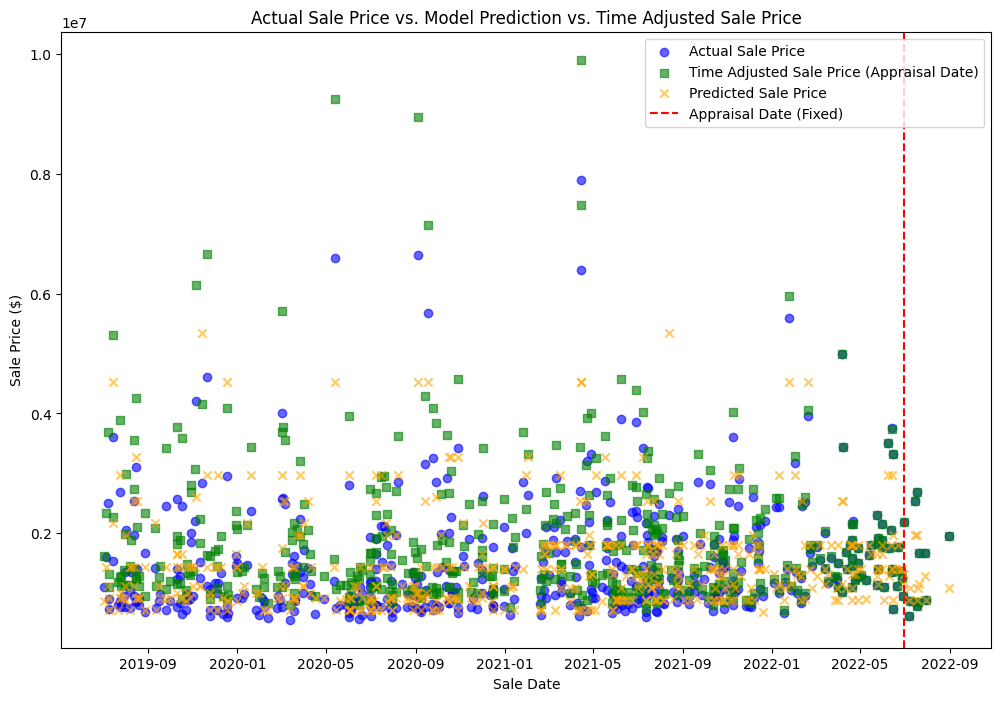

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)

# R-squared Score
test_r2 = r2_score(y_test, y_pred_test)

# Mean Absolute Error (for interpretability)
test_mae = mean_absolute_error(y_test, y_pred_test)

# Print results
print(f"🔹 Test RMSE: $ {test_rmse:.2f}")
print(f"🔹 Test R²: {test_r2:.3f}")
print(f"🔹 Test MAE: $ {test_mae:.2f}")
print()

# Feature Importance for decision tree regressor
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(feature_importance)

# Ensure sale dates and appraisal dates are in datetime format
boulder_sales_2024_df["Sale Date"] = pd.to_datetime(boulder_sales_2024_df["Sale Date (Mon-Yr)"])
plt.figure(figsize=(12, 8))

actual_sale_dates = boulder_sales_2024_df.loc[y_test.index, "Sale Date"]
actual_sale_prices = boulder_sales_2024_df.loc[y_test.index, "Sale Price"]
y_test_tasp = boulder_sales_2024_df.loc[y_test.index, "Time Adjust Sales Price"]

# Scatter plot of Actual Sale Price over Sale Date
plt.scatter(
    actual_sale_dates,
    actual_sale_prices,
    color="blue",
    alpha=0.6,
    label="Actual Sale Price",
    marker="o"
)

# Scatter plot of Time Adjusted Sale Price, all pinned to Appraisal Date
plt.scatter(
    actual_sale_dates,
    y_test_tasp,
    color="green",
    alpha=0.6,
    label="Time Adjusted Sale Price (Appraisal Date)",
    marker="s"
)

# Scatter plot of Model-Predicted Sale Price at Actual Sale Date
plt.scatter(
    actual_sale_dates,
    y_pred_test,
    color="orange",
    alpha=0.6,
    label="Predicted Sale Price",
    marker="x"
)

# Labels and title
plt.xlabel("Sale Date")
plt.ylabel("Sale Price ($)")
plt.title("Actual Sale Price vs. Model Prediction vs. Time Adjusted Sale Price")

# Add a vertical line for the fixed appraisal date
plt.axvline(boulder_official_appraisal_date, color="red", linestyle="--", label="Appraisal Date (Fixed)")

# Legend
plt.legend()
plt.show()

### Feature Importance Review

Plot the importance of the features to inform future work.

NOTE: A great feature of the decision tree's model is interpretability: its ability to report the relative importance of each feature (the number of times a feature was used to split the data in the branching decision tree). This is referred to as the F-score of a feature.

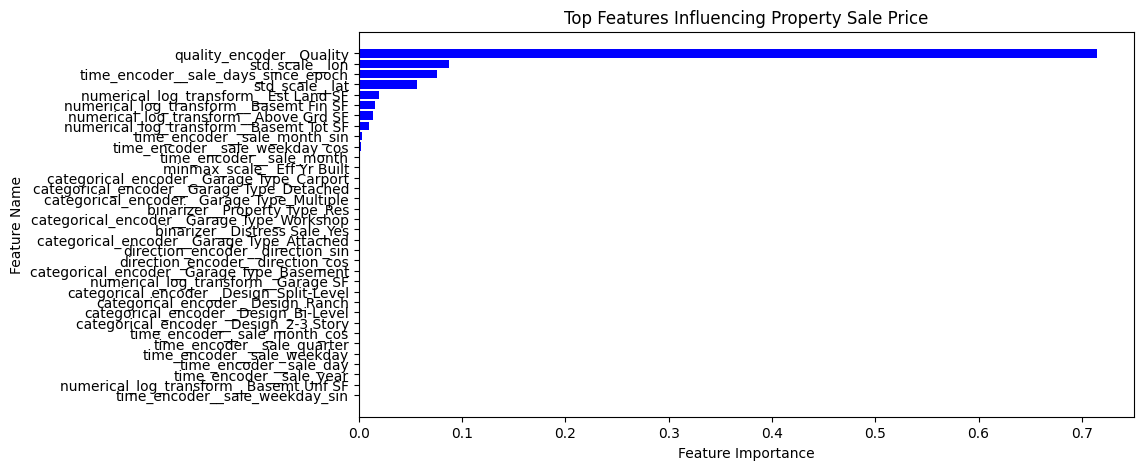

In [173]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
feature_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(feature_importances["Feature"], feature_importances["Importance"], color="blue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top Features Influencing Property Sale Price")
plt.gca().invert_yaxis()  # Most important feature at the top
plt.show()

## Time Trend Factors

Accuracy of time trend factors and future model considerations (away from interpretability and in pursuit of accuracy)

1. Random Forest Regressor
2. Surface explainability of time trend analysis from ML contractor

[This home](https://www.zillow.com/homedetails/4990-Ricara-Dr-Boulder-CO-80303/13189208_zpid/) sold in December 2024 at $378 per sqft

- quality is a class above my home
- using $/sqft of this recently sold home would put ours at $770,000, not $1,000,000 based on 

[2480000.00000008  999000.00000004 1050000.00000004  787000.00000003
 1700800.00000006 3600000.00000015 1395000.00000005 3325000.00000012
 1200000.00000005 1440000.00000005 1825000.00000006 4995000.00000018
  960000.00000004 4000000.00000018  750000.00000003  580000.00000002
  633000.00000002  611000.00000002 1800000.00000006 1000000.00000004
 2750000.0000001  1450000.00000005 1825000.00000006  735000.00000003
 6650000.00000024 1752000.00000006 2215000.00000008 3100000.00000011
 1370000.00000005 3150000.00000013  757500.00000003 1060000.00000004
 2450000.00000009  936000.00000003 2225000.00000008 1240000.00000005
 1275000.00000004 1000000.00000004 1250000.00000005 1252000.00000005
  983000.00000004  985000.00000004 1520000.00000005  750000.00000003
  830000.00000003 2695000.00000012 1975000.00000007 2187500.00000009
 2450000.00000011 1870000.00000007 1670000.00000006 1195000.00000004
 1076000.00000004 1206750.00000004  628000.00000002 1000000.00000004
 1510000.00000007  784000.00000003